<a href="https://colab.research.google.com/github/OdinProjectI/ODIN/blob/main/CasualtiesOfWarInAfghanistan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fatalities of War in Afghanistan**
1. Exploring Fatalities
    - Fatalities by Area
    - Fatalities by Types (Civilian v.s Non-civilian)
    - Fatalities by Perpetrators  
    - Fatalities involving U.S Military (Drones Related)
    - Seasonal Fatalities
2. Northern Afghanistan
    - Perpetrators
    - Events
3. Forecasting Casualties
    - SARIMAX Model

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/22/SpecialForces_Badge.svg/1024px-SpecialForces_Badge.svg.png" width='500px' style="text-align:center">

In [2]:
%%capture
! pip install squarify

In [3]:
import pandas as pd
import numpy as np
import warnings
import os
import urllib
from bs4 import BeautifulSoup
import re
import math
from collections import defaultdict

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from itertools import product
from sklearn import metrics

import seaborn as sns
import matplotlib.pyplot as plt
import squarify as sq
import plotly.express as px
from matplotlib.colors import ListedColormap

from typing import List, Dict
warnings.filterwarnings('ignore')

In [5]:
afghan_weather: Dict = {
    "Spring": range(3,6),
    "Summer": range(6,9),
    "Autumn": range(9,12),
    "Winter": [12,1,2]
}

afghan_df: 'DataFrame' = pd.read_csv(os.environ['DATASET'])
afghan_df['event_date'] = pd.to_datetime(afghan_df['event_date'])
afghan_df['is_civilian_fatality'] = afghan_df['civilian_targeting'].replace({'Civilian targeting': 1, np.nan:0}) # label civilian v.s non-civilian fatalities
afghan_df['incident_month'] = afghan_df['event_date'].apply(lambda row: row.month_name() )
months: List[str] = pd.Series(pd.date_range(start="2021-01-01", end="2021-12-01", freq='M')).apply(lambda row: row.month_name() ).tolist()
afghan_weather: Dict = {
    "Spring": range(3,6),
    "Summer": range(6,9),
    "Autumn": range(9,12),
    "Winter": [12,1,2]
}

afghan_df['season'] = afghan_df['event_date'].apply(lambda row: "Spring" if row.month in afghan_weather.get("Spring") else 'Summer' if row.month in afghan_weather.get("Summer") else 'Autumn' if row.month in afghan_weather.get("Autumn") else 'Winter' )

pd.options.display.max_columns = afghan_df.shape[1]

In [ ]:
afghan_df.head(5)

,event_id_cnty,event_date,year,time_precision,disorder_type,event_type,sub_event_type,actor1,assoc_actor_1,inter1,actor2,assoc_actor_2,inter2,interaction,civilian_targeting,iso,region,country,admin1,admin2,admin3,location,latitude,longitude,geo_precision,source,source_scale,notes,fatalities,tags,timestamp
0,AFG66781,2023-07-13,2023,1,Political violence,Battles,Armed clash,Military Forces of Afghanistan (2021-),NaN,1,Military Forces of Afghanistan (2021-),NaN,1,11,NaN,4,Caucasus and Central Asia,Afghanistan,Nangarhar,Kama,NaN,Kama,34.4432,70.6565,2,Hasht-e Subh,National,"On 13 July 2023, a Taliban commander and the K...",0,NaN,1689690645
1,AFG66784,2023-07-13,2023,1,Political violence,Battles,Armed clash,Unidentified Armed Group (Afghanistan),NaN,3,TTP: Tehreek-i-Taliban Pakistan,NaN,2,23,NaN,4,Caucasus and Central Asia,Afghanistan,Paktika,Sharan,NaN,Sharan,33.1757,68.7304,1,Hasht-e Subh,National,"On 13 July 2023, one Tehreek-i-Taliban Pakista...",1,NaN,1689690645
2,AFG66796,2023-07-13,2023,2,Strategic developments,Strategic developments,Disrupted weapons use,Police Forces of Afghanistan (2021-),NaN,1,Unidentified Armed Group (Afghanistan),NaN,3,13,NaN,4,Caucasus and Central Asia,Afghanistan,Balkh,Mazar-e-Sharif,NaN,Mazar-e-Sharif,36.7090,67.1109,3,Afghan Islamic Press News Agency,National,"Weapons seizure: Around 13 July 2023, Taliban ...",0,NaN,1689690645
3,AFG66802,2023-07-12,2023,2,Strategic developments,Strategic developments,Other,Government of Afghanistan (2021-),NaN,1,Civilians (Afghanistan),Teachers (Afghanistan); Students (Afghanistan),7,17,NaN,4,Caucasus and Central Asia,Afghanistan,Kabul,Kabul,NaN,Kabul,34.5167,69.1833,1,Independent Persian; Twitter; Zawia News,New media-Subnational,"Other: Around 12 July 2023 (as reported), the ...",0,NaN,1689690645
4,AFG66803,2023-07-12,2023,1,Strategic developments,Strategic developments,Other,Unidentified Armed Group (Afghanistan),NaN,3,Civilians (Afghanistan),NaN,7,37,NaN,4,Caucasus and Central Asia,Afghanistan,Nangarhar,Deh Bala,NaN,Deh Bala,34.0923,70.4690,2,Afghan Islamic Press News Agency; Etilaat e Ro...,National-International,"Explosive remnants of war: On 12 July 2023, tw...",2,NaN,1689690645


## **Trends of Fatalities in Afghanistan**

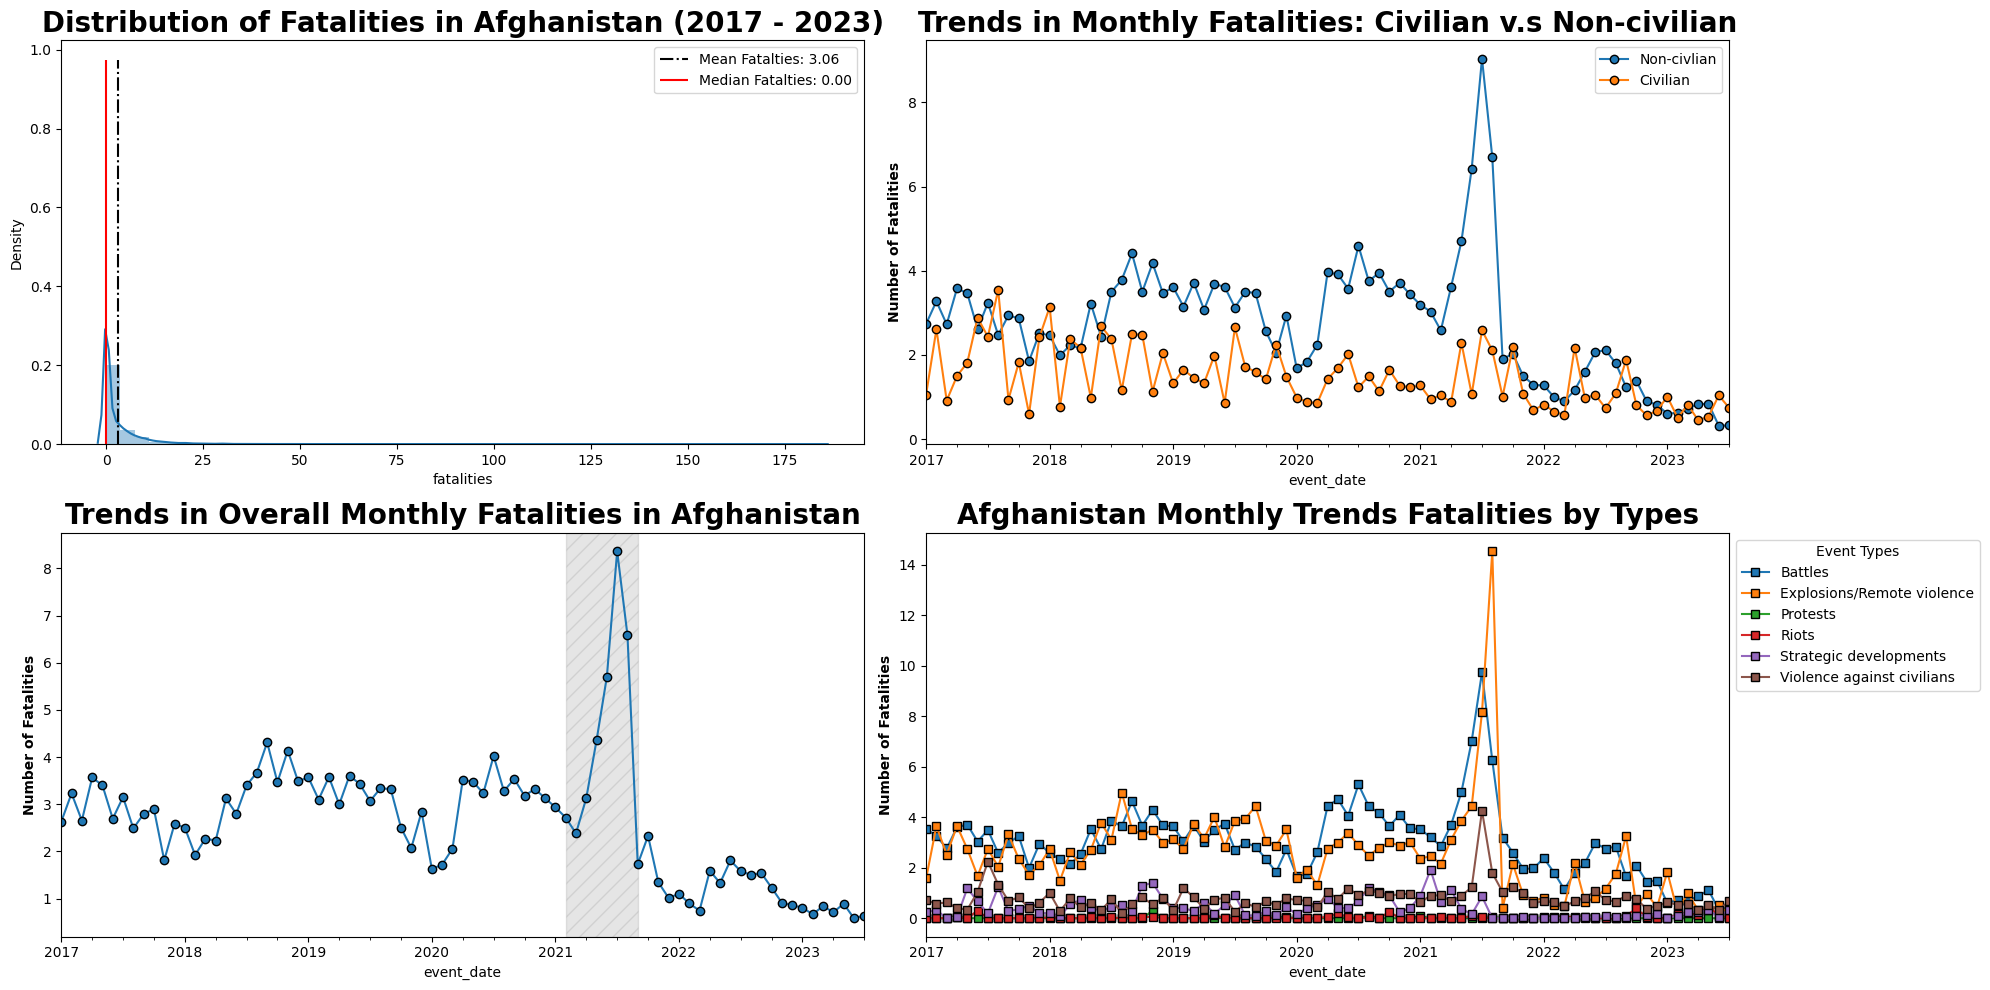

In [ ]:
mean_fatalities: float = afghan_df['fatalities'].mean()
median_fatalities: float = afghan_df['fatalities'].median()

fig = plt.figure(figsize=(35,10))
ax = fig.add_subplot(2,2,1)
sns.distplot(afghan_df['fatalities'], ax=ax)
ax.set_title("Distribution of Fatalities in Afghanistan (2017 - 2023)", fontweight='bold', fontsize=20)

ax.vlines(mean_fatalities,
           ymin=0.0,
           ymax=0.975,
           label=f"Mean Fatalties: {mean_fatalities:.2f}",
           linestyle="-.",
           color='black')

ax.vlines(median_fatalities,
           ymin=0.0,
           ymax=0.975,
           label=f"Median Fatalties: {median_fatalities:.2f}",
           linestyle="solid",
           color='red')

ax.legend()

ax = fig.add_subplot(2,2,2)
afghan_df.groupby(['event_date', 'is_civilian_fatality'])['fatalities'].mean().unstack("is_civilian_fatality").replace({np.nan:0.0}).rename({0.0: 'Non-civlian', 1.0: 'Civilian'}, axis=1).resample('M').mean().plot(marker='o', mec='black', ax=ax)
ax.set_title("Trends in Monthly Fatalities: Civilian v.s Non-civilian", fontweight='bold', fontsize=20)
ax.set_ylabel("Number of Fatalities", fontweight='bold')

plt.legend()

ax = fig.add_subplot(2,2,3)
afghan_df.groupby('event_date')['fatalities'].mean().resample("M").mean().plot(ax=ax, marker='o', mec='black') # Jan 2021 - 2022

ax.axvspan(xmin=pd.to_datetime('2021-02-28 '), xmax=pd.to_datetime('2021-09-30'), alpha=0.2, color='grey' , hatch="//")
ax.set_title("Trends in Overall Monthly Fatalities in Afghanistan", fontweight='bold', fontsize=20)
ax.set_ylabel("Number of Fatalities", fontweight='bold')

ax = fig.add_subplot(2,2,4)
afghan_df.groupby(['event_date', 'event_type'])['fatalities'].mean().unstack("event_type").replace({np.nan:0.0}).resample("M").mean().plot(figsize=(20,10), marker='s', mec='black', ax=ax)
ax.set_title("Afghanistan Monthly Trends Fatalities by Types", fontweight='bold', fontsize=20)
ax.set_ylabel("Number of Fatalities", fontweight='bold')
ax.legend(title="Event Types", bbox_to_anchor=(1,1))
plt.tight_layout()

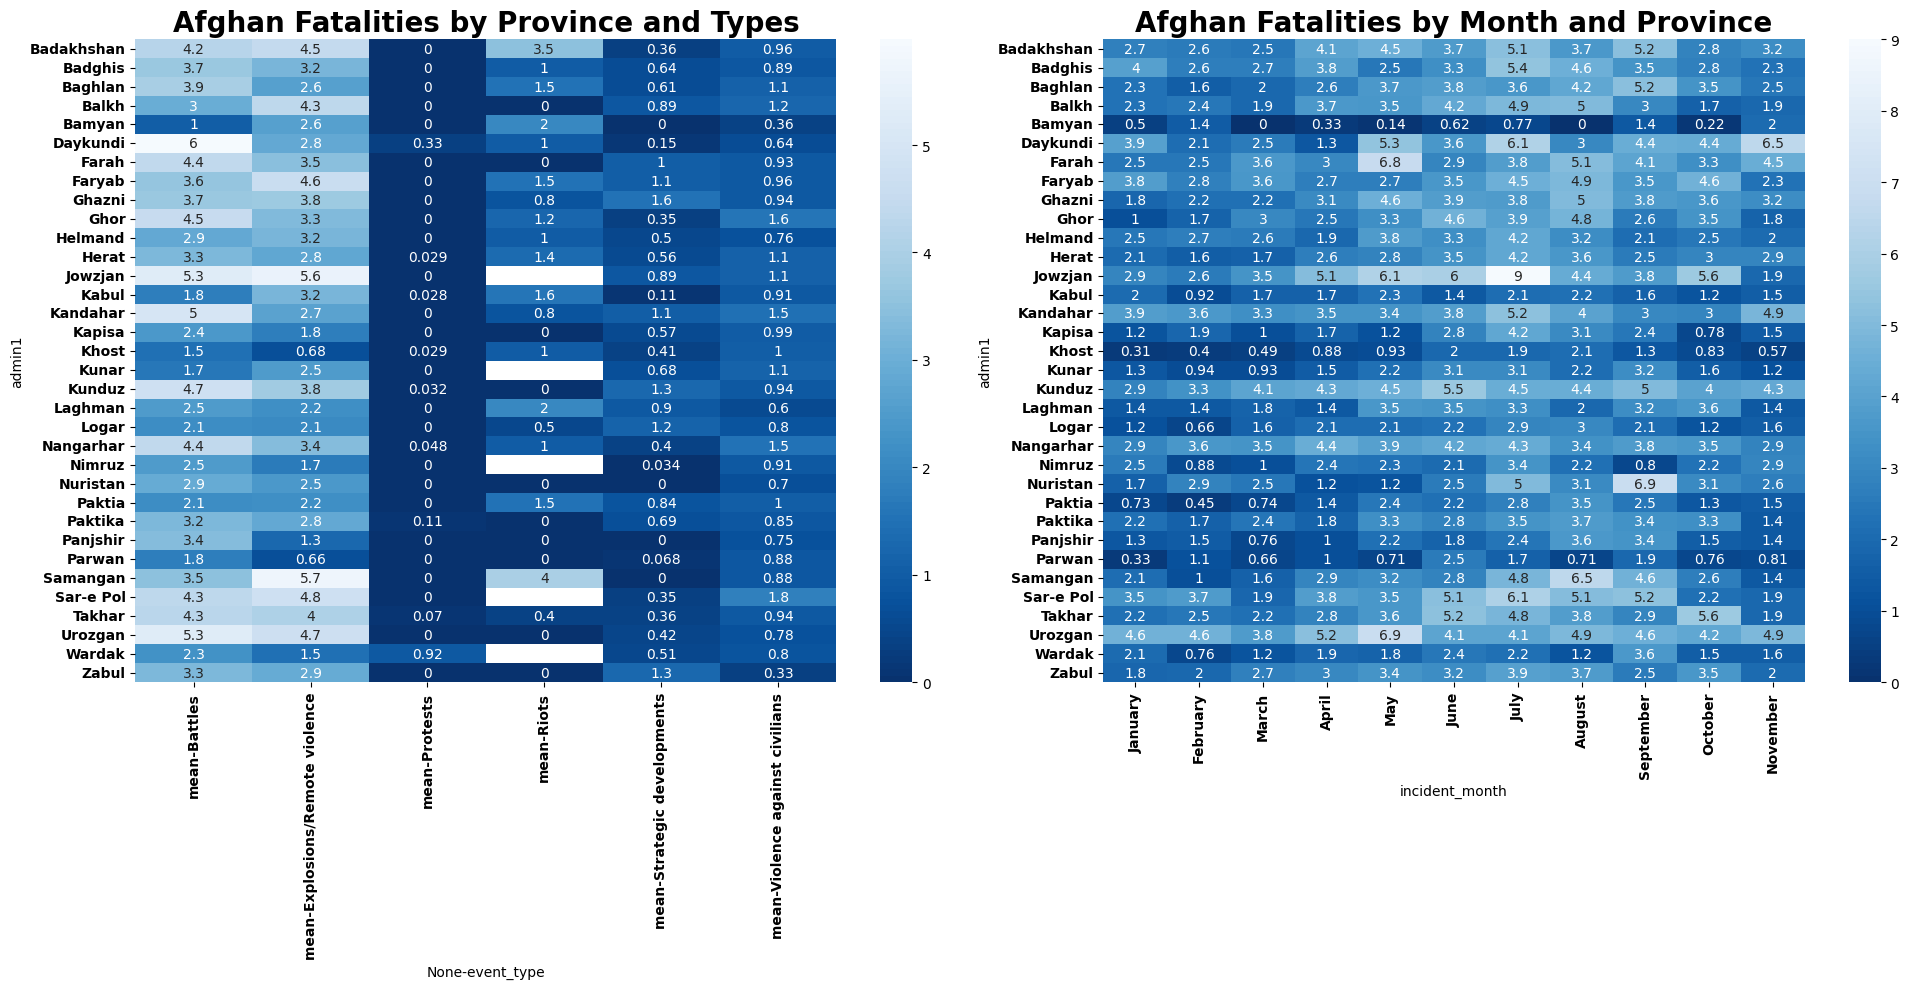

In [ ]:
fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(1,2,1)
sns.heatmap(afghan_df.groupby(['event_type', 'admin1'])['fatalities'].agg(['mean']).unstack("event_type"),
            ax=ax,
            annot=True,
            cmap=ListedColormap(sns.color_palette(palette='Blues_r', n_colors=100)))

ax.set_title("Afghan Fatalities by Province and Types", fontweight='bold', fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold')
ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold')

ax = fig.add_subplot(1,2,2)
df: 'DataFrame' = pd.pivot_table(data=afghan_df, columns='incident_month', index=['admin1'], values='fatalities', aggfunc='mean').replace({np.nan: 0.0}).sort_values(by=afghan_df['admin1'].tolist(), axis=1, ascending=False)[months]
sns.heatmap(df,
            ax=ax,
            annot=True,
            cmap=ListedColormap(sns.color_palette(palette='Blues_r', n_colors=100)))

ax.set_title("Afghan Fatalities by Month and Province", fontweight='bold', fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold')
ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold')

plt.tight_layout()


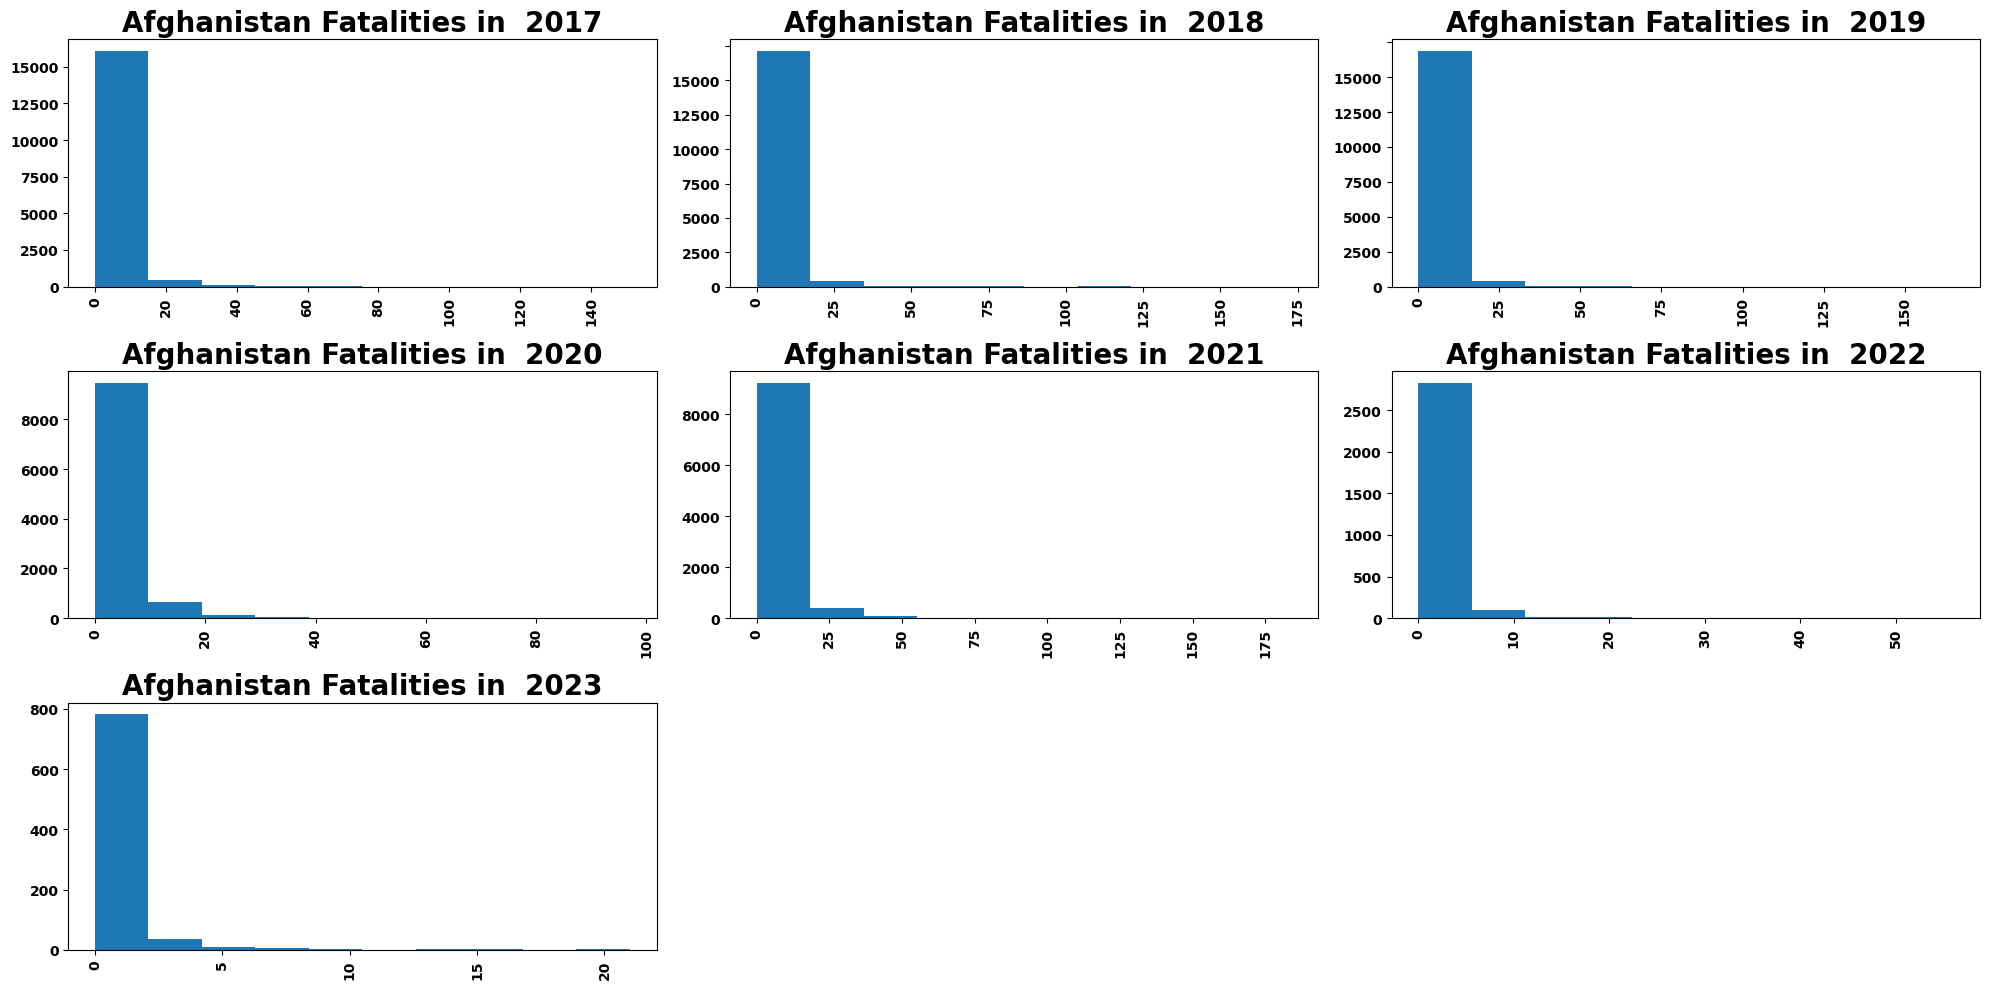

In [41]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot()
axs = afghan_df.hist(by='year', column='fatalities', ax=ax)
years: List[int] = list(range(2017, 2024))
for index,axis in enumerate(axs.ravel()):

    if index < len(years):
        axis.set_title("Afghanistan Fatalities in  %s" % (years[index]), fontweight='bold', fontsize=20)
        axis.set_xticklabels(axis.get_xticklabels(), fontweight='bold')
        axis.set_yticklabels(axis.get_yticklabels(), fontweight='bold')



plt.tight_layout()

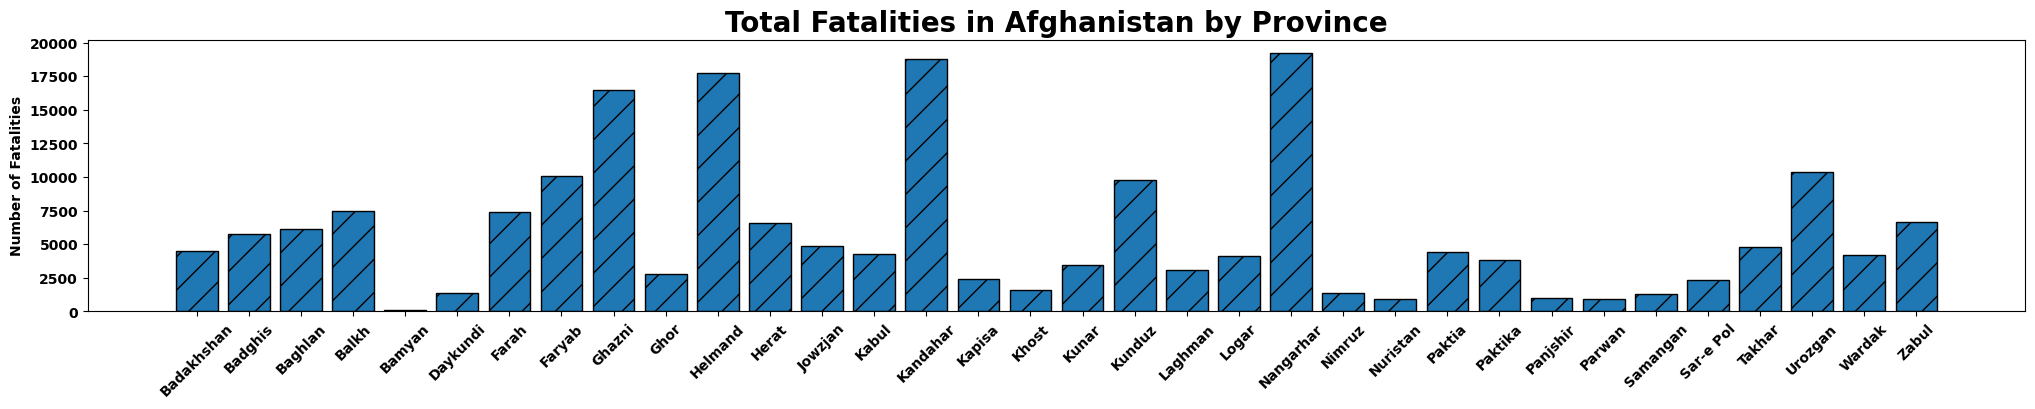

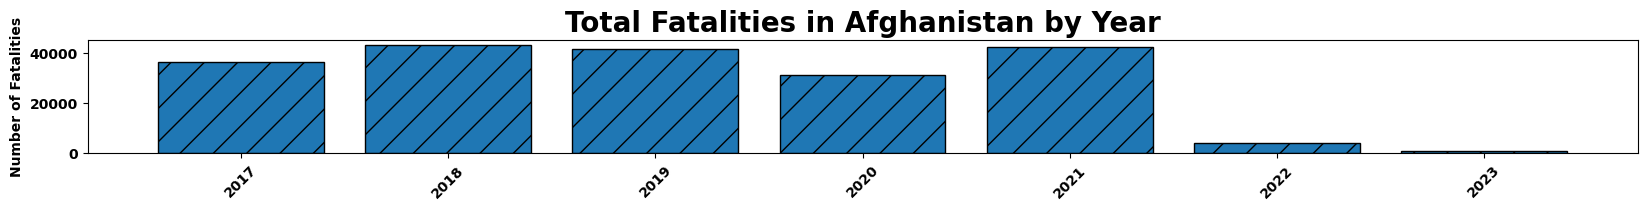

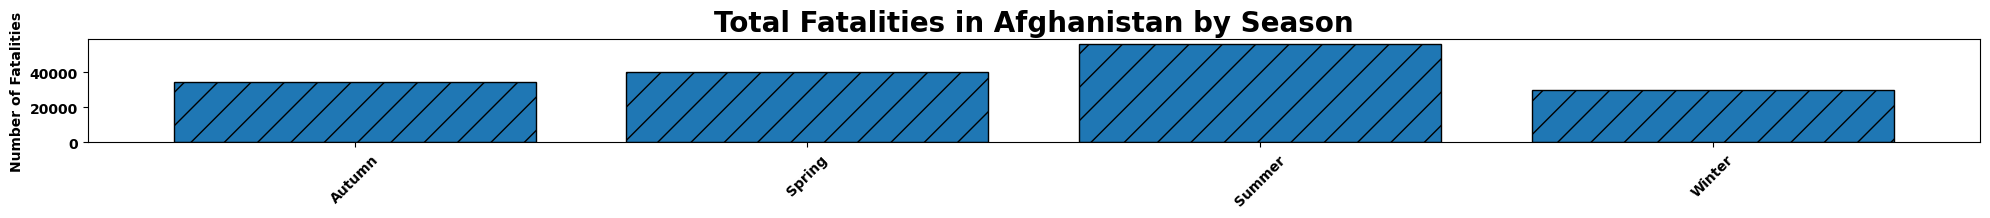

In [9]:
provinces, fatalities = zip(*afghan_df.groupby(['admin1'])['fatalities'].sum().to_dict().items())
fig = plt.figure(figsize=(25,12))
ax = fig.add_subplot(3,1,1)

ax.bar(x=list(provinces), height=list(fatalities) , align='center', edgecolor='k', hatch="/" )
ax.set_title("Total Fatalities in Afghanistan by Province", fontweight='bold', fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold', rotation=45)
ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold')
ax.set_ylabel("Number of Fatalities", fontweight='bold')

afg_year, fatalities = zip(*afghan_df.groupby(['year'])['fatalities'].sum().to_dict().items())
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(3,1,2)

ax.bar(x=list(afg_year), height=list(fatalities) , align='center', edgecolor='k', hatch="/" )
ax.set_title("Total Fatalities in Afghanistan by Year", fontweight='bold', fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold', rotation=45)
ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold')
ax.set_ylabel("Number of Fatalities", fontweight='bold')


afg_season, fatalities = zip(*afghan_df.groupby(['season'])['fatalities'].sum().to_dict().items())
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(3,1,2)

ax.bar(x=list(afg_season), height=list(fatalities) , align='center', edgecolor='k', hatch="/" )
ax.set_title("Total Fatalities in Afghanistan by Season", fontweight='bold', fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold', rotation=45)
ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold')
ax.set_ylabel("Number of Fatalities", fontweight='bold')

plt.tight_layout()

# **Afghanistan Fatalities involving U.S Military**

In [100]:
us_fatalities: 'DataFrame' = afghan_df[afghan_df['actor1'].apply(lambda row: 'United' in row)]
us_fatalities[['admin1', 'event_type', 'actor1', 'actor2', 'latitude', 'longitude', 'fatalities', 'notes', 'source']].sort_values(by=['latitude', 'longitude'])

,admin1,event_type,actor1,actor2,latitude,longitude,fatalities,notes,source
3015,Helmand,Explosions/Remote violence,Military Forces of the United States (2021-),Military Forces of Afghanistan (2021-),31.8664,64.1923,15,"On 30 March 2022, at least 30-36 Taliban membe...",Etilaat e Roz; Afghan Islamic Press News Agenc...
7545,Logar,Explosions/Remote violence,Military Forces of the United States (2021-),Civilians (Afghanistan),33.9953,69.0227,0,"Around 5 June 2021 (as reported), 2 civilians,...",Voice of Jihad
1851,Kabul,Explosions/Remote violence,Police Forces of the United States (2021-) Cen...,Al Qaeda,34.5167,69.1833,1,"On 31 July 2022, Ayman Al-Zawahri, the leader ...",AP; Afghan Islamic Press News Agency; Twitter;...
22059,Kabul,Strategic developments,Government of the United States (2017-2021),Taliban,34.5167,69.1833,0,"Agreement: on 29 February 2020, the Taliban an...",Bakhtar News Agency
39069,Parwan,Explosions/Remote violence,Military Forces of the United States (2017-2021),Civilians (Afghanistan),35.1183,69.2378,0,"On 23 November 2018, 3 Afghan civilians were k...",Voice of Jihad
49977,Balkh,Explosions/Remote violence,Military Forces of the United States (2017-2021),Civilians (Afghanistan),36.6782,66.8033,0,"On 25 February 2018, 2 civilian children were ...",Voice of Jihad
39082,Kunduz,Explosions/Remote violence,Military Forces of the United States (2017-2021),Civilians (Afghanistan),37.0704,69.2984,0,"On 22 November 2018, 5 Afghan civilians were k...",Voice of Jihad


In [95]:
fig = px.scatter_mapbox(us_fatalities, **dict(lat="latitude",
                                        lon="longitude",
                                        mapbox_style="open-street-map",
                                        size='fatalities',
                                        width=1500,
                                        height=700,
                                        opacity=0.5,
                                        color_discrete_sequence=sns.color_palette(n_colors=7, palette='flare_r').as_hex(),
                                        title='Afghanistan Fatalities involving U.S Military',
                                        zoom=5))

fig.update_layout(title={'font': {'size': 50}},
                  font_family="Courier New"
                  )



# **Perpetrators Operating in Afghanistan**

In [66]:
# TODO: Prep: ISI, AL-Q, Tlb (Northern Afg) activities

## **Fatalities Seasonal Trend**

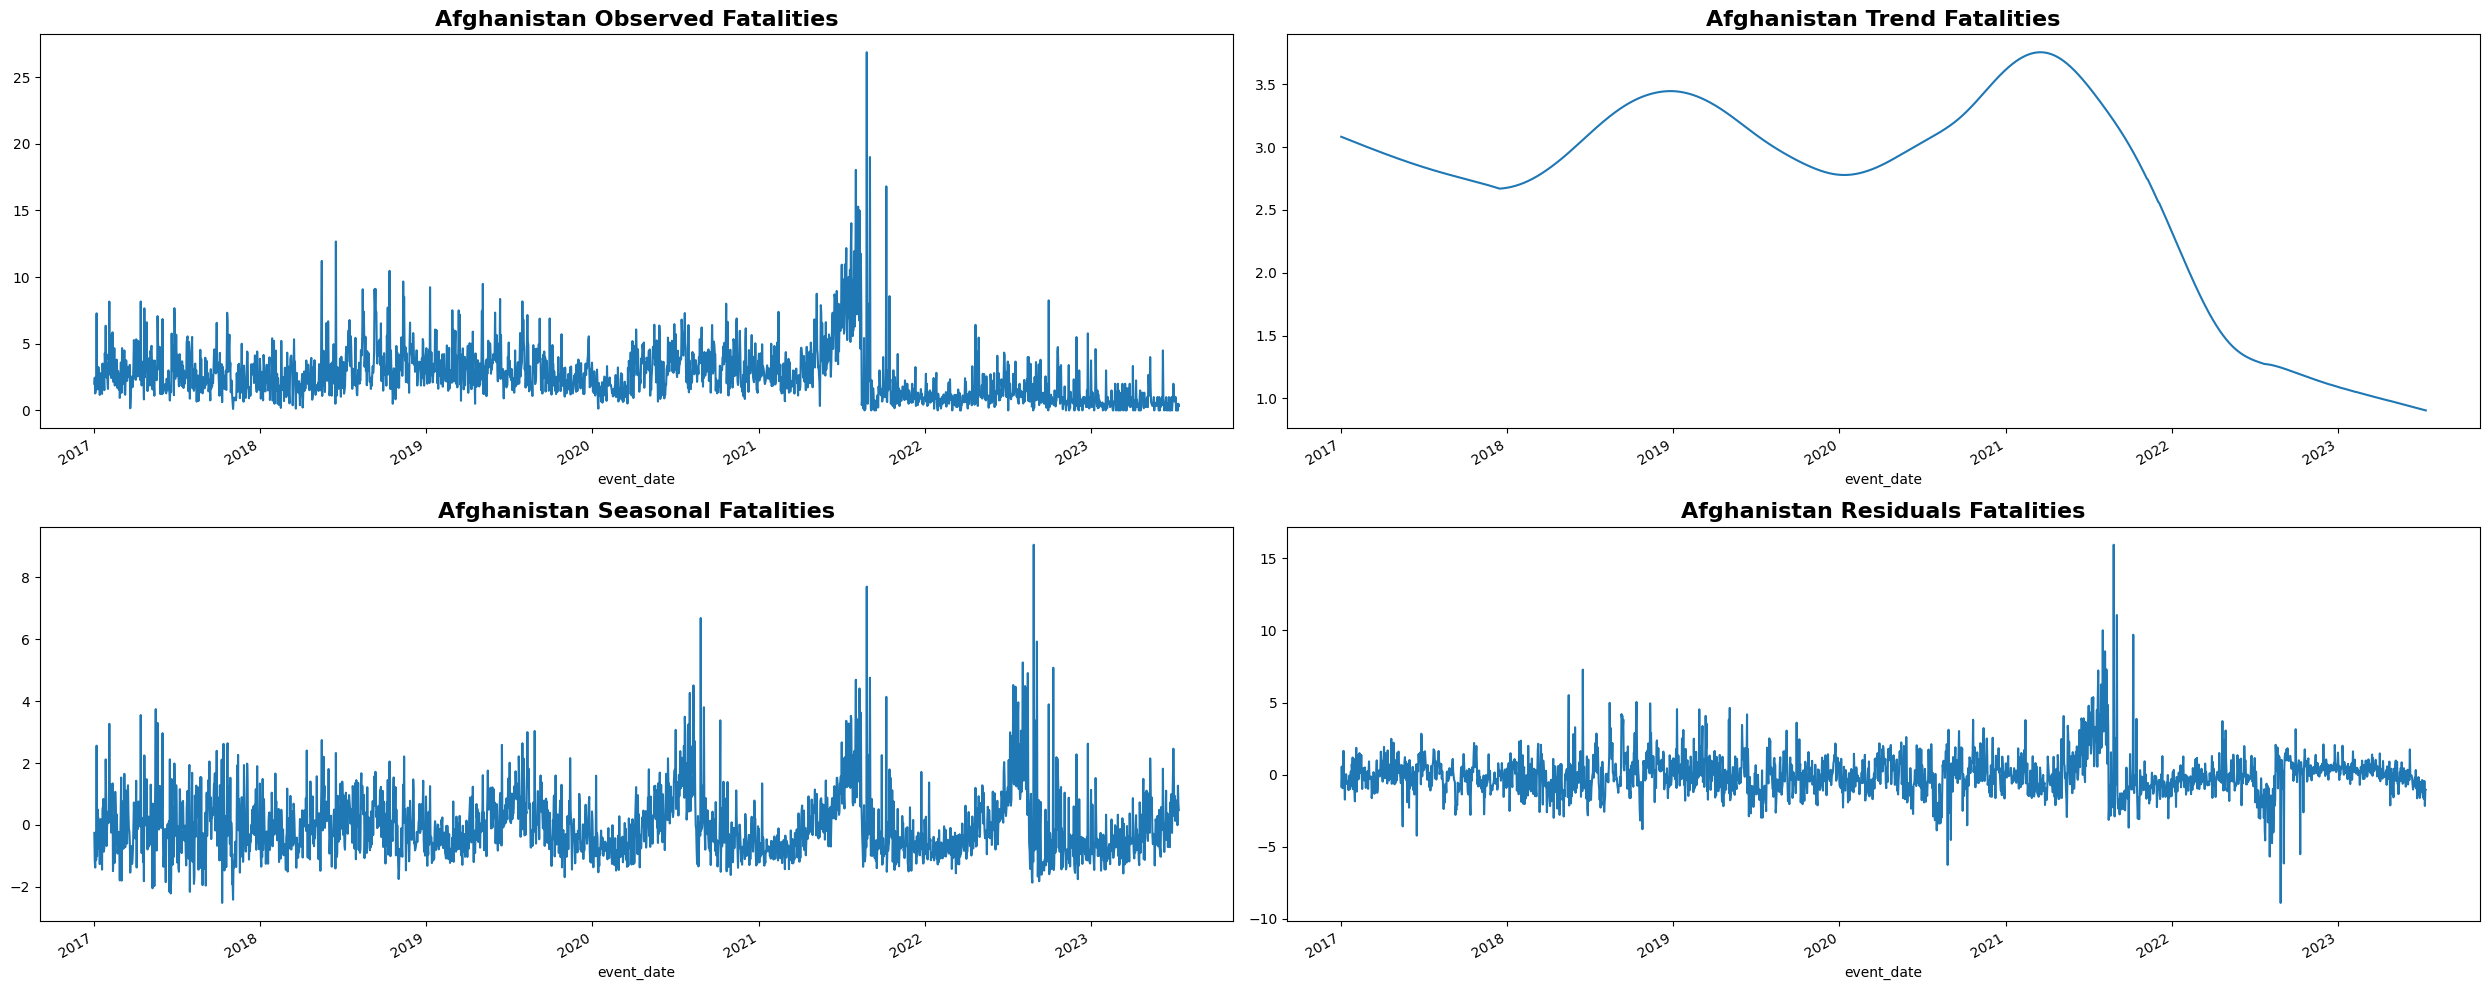

In [ ]:
fatalities_stl: 'STL' = STL(afghan_df.groupby('event_date')['fatalities'].mean(), period=365).fit() # .plot() # mean overall fatalities
fig = plt.figure(figsize=(25, 10))

ax = fig.add_subplot(2,2,1)
fatalities_stl.observed.plot(ax=ax)
ax.set_title("Afghanistan Observed Fatalities", fontweight='bold', fontsize=16)

ax = fig.add_subplot(2,2,2)
fatalities_stl.trend.plot(ax=ax)
ax.set_title("Afghanistan Trend Fatalities", fontweight='bold', fontsize=16)

ax = fig.add_subplot(2,2,3)
fatalities_stl.seasonal.plot(ax=ax)
ax.set_title("Afghanistan Seasonal Fatalities", fontweight='bold', fontsize=16)

ax = fig.add_subplot(2,2,4)
fatalities_stl.resid.plot(ax=ax)
ax.set_title("Afghanistan Residuals Fatalities", fontweight='bold', fontsize=16)

plt.tight_layout()

# **Fatalities Model by Province**
    1. North East Afghanistan
    2. North West Afghanistan
    3. Central Afghanistan
    4. Eastern Afghanistan
    5. Western Afghanistan
    6. South East Afghanistan
    7. South West Afghanistan

In [73]:
province_lookup: defaultdict = defaultdict(list)
resp: str = urllib.request.urlopen("https://en.wikipedia.org/wiki/Districts_of_Afghanistan#Northern_Afghanistan").read()
soup: 'BeautifulSoup' = BeautifulSoup(resp)

for tag in soup.find_all("ul"):

    current_key: str = ""
    if "Afghanistan-sublist" in tag.get('id', ''):
        for item in tag.find_all('div'):
            curr_row: List[str] = item.text.split(".")

            if len(curr_row) == 2:
                current_key: str = re.sub(r'[0-9]+', '', curr_row[-1])
                # province_lookup[current_key].append('')

            else:
                province_lookup[current_key].append( re.sub(r'[0-9]+', '', curr_row[-1]).replace("Province", "").strip() )

stdout = province_lookup.pop('')

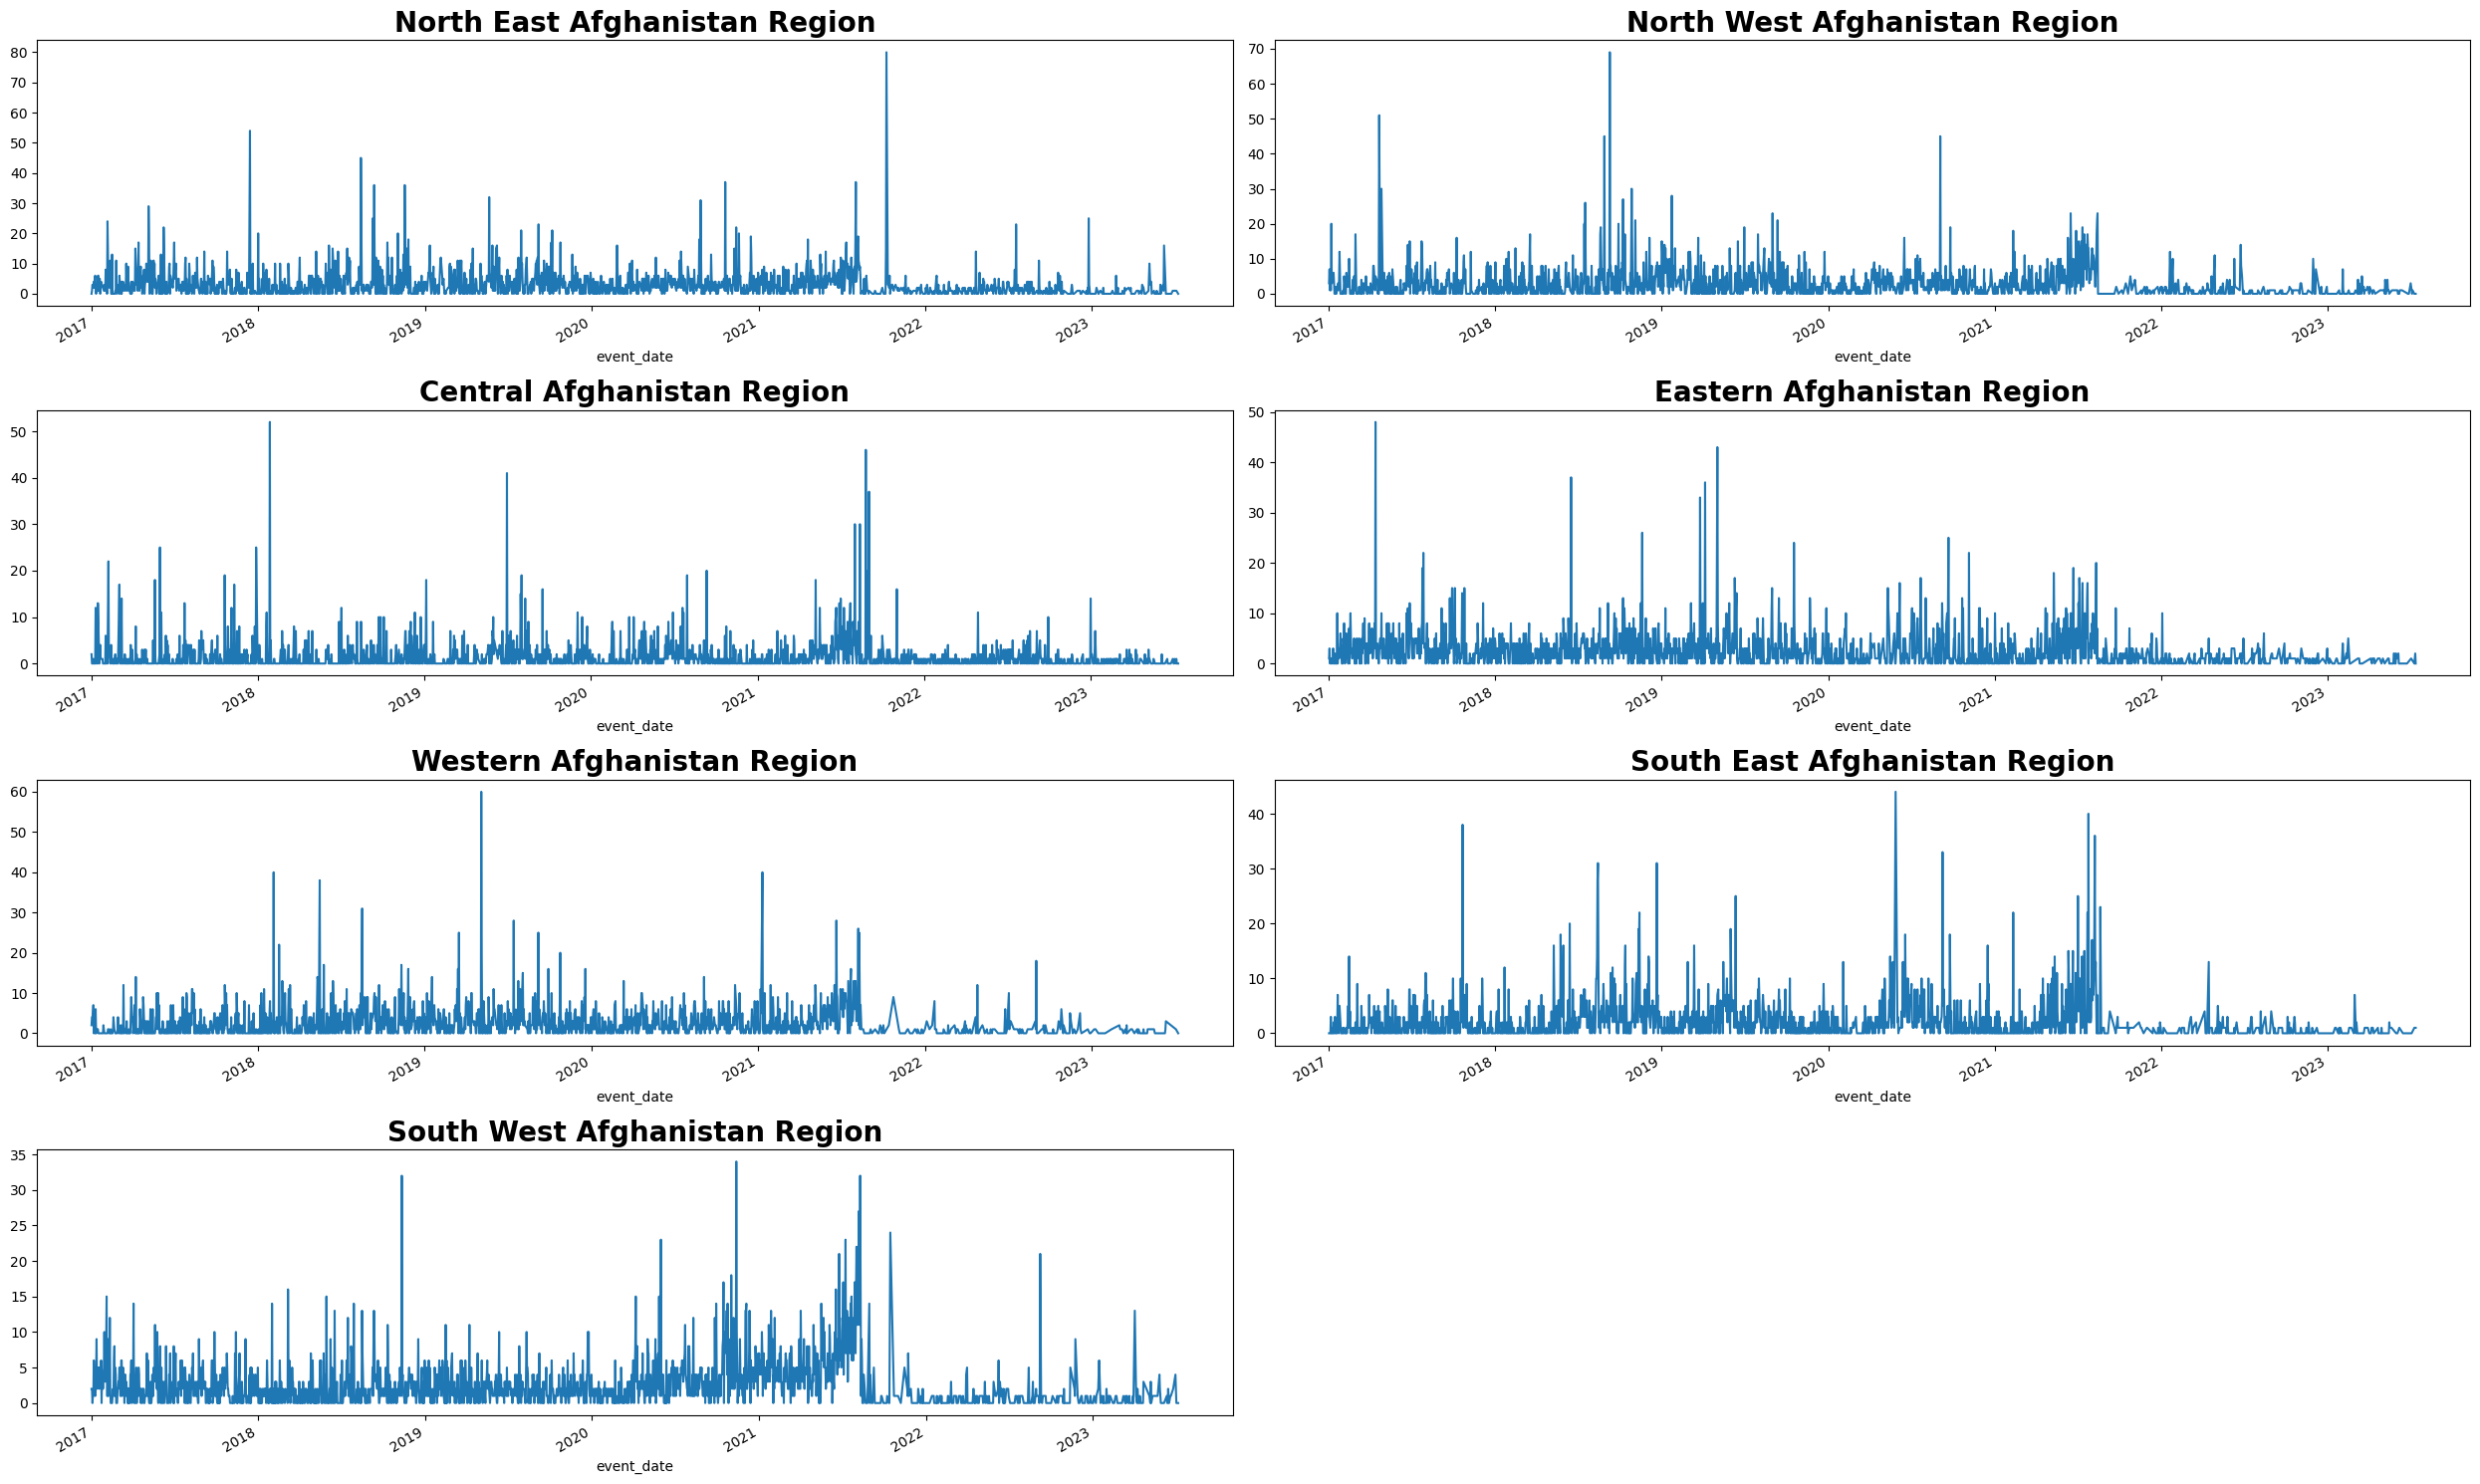

In [109]:
fig = plt.figure(figsize=(25,15))
index: int = 1

for prov_name,areas in province_lookup.items():
    ax = fig.add_subplot(4,2,index)
    afghan_df[afghan_df['admin1'].isin(areas) ].groupby('event_date')['fatalities'].mean().apply(lambda row: math.trunc(row)).plot(ax=ax)
    ax.set_title("%s Region" % (prov_name), fontweight='bold', fontsize=20 )
    index += 1

plt.tight_layout()

# **SARIMAX Model**
    - exogenous factors:
        - Afhanistan Province
        - Type of Attacks
        - Months
        - Season

In [10]:
afghan_df["mapped_month"] = afghan_df['incident_month'].factorize()[0]
afghan_df['mapped_event_type'] = afghan_df['event_type'].factorize()[0]
afghan_df['mapped_season'] = afghan_df['season'].factorize()[0]
afghan_df['mapped_province'] = afghan_df['admin1'].factorize()[0]

afghan_df.groupby(['year', 'season'])['fatalities'].sum().unstack("season").replace({np.nan:0.0}).astype(int)

season,Autumn,Spring,Summer,Winter
year,,,,
2017,8161,11249,9946,7247
2018,11748,9344,13973,8199
2019,11352,9366,12121,8781
2020,9966,6114,9151,6128
2021,984,12392,23293,5988
2022,842,1180,1313,697
2023,0,338,84,205


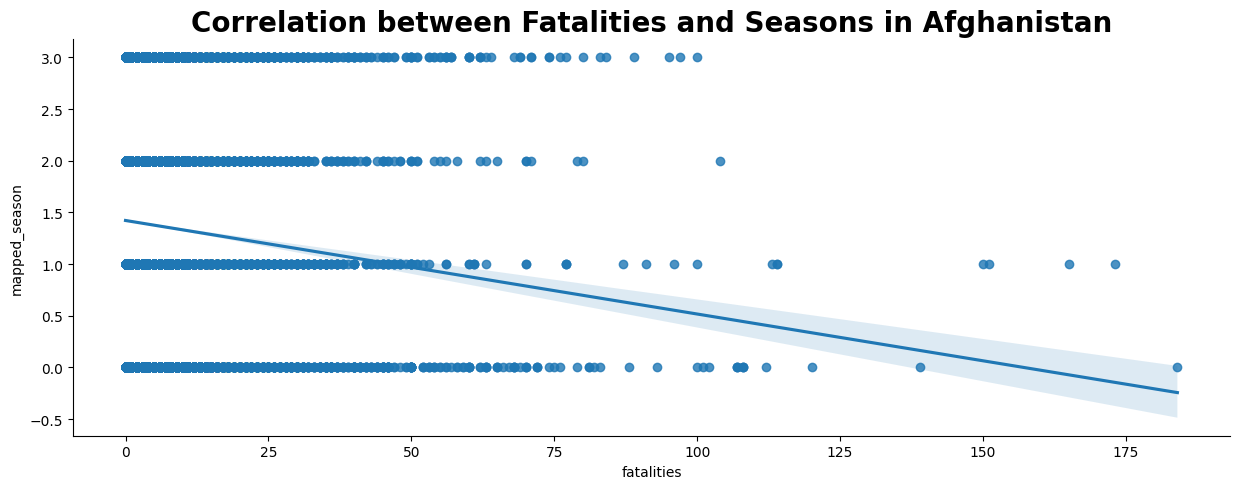

In [51]:
ax = sns.lmplot(data=afghan_df, x='fatalities', y='mapped_season', aspect=2.5)
plt.title("Correlation between Fatalities and Seasons in Afghanistan", fontweight='bold', fontsize=20)

plt.tight_layout()

## **Autocorrelation and Partial Correlation: Overall Fatalities**

Text(0.5, 1.0, 'Partial-Autocorrelation: Overall Fatalities in Afghanistan')

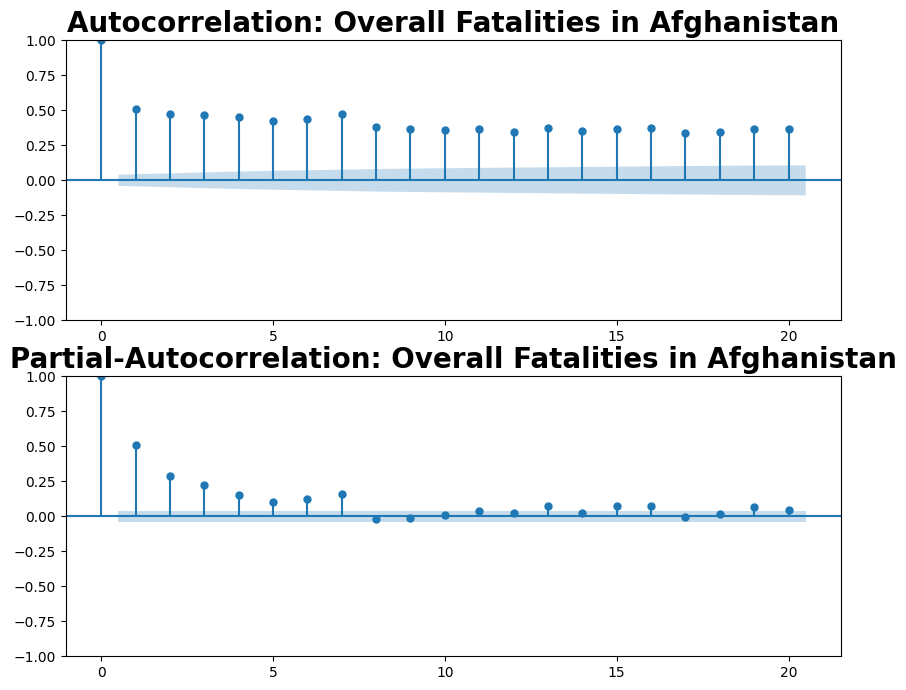

In [57]:
overall_fatalities: 'Series' = pd.Series(afghan_df.groupby('event_date')['fatalities'].mean()).apply(lambda row: round(row))
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(2,1,1)

plot_acf(overall_fatalities, lags=20, ax=ax)
ax.set_title("Autocorrelation: Overall Fatalities in Afghanistan", fontweight='bold', fontsize=20)

ax = fig.add_subplot(2,1,2)
plot_pacf(overall_fatalities, lags=20, ax=ax)
ax.set_title("Partial-Autocorrelation: Overall Fatalities in Afghanistan", fontweight='bold', fontsize=20)

## **Adfuller Test**
    - Integration Order: d = 1
    - Seasonal Integration Order: D = 0

In [62]:
adf_test: 'adfuller' = adfuller(overall_fatalities)
pd.DataFrame({'ADF': adf_test[0],
              'P-Value': adf_test[1]
              }, index=['ADF Test']).transpose()

,ADF Test
ADF,-3.235119
P-Value,0.018040


In [63]:
diff_one: 'adfulller' = adfuller(np.diff(overall_fatalities, n=1))
pd.DataFrame({'ADF': diff_one[0],
              'P-Value': diff_one[1]
              }, index=['ADF Diff-1']).transpose()

,ADF Diff-1
ADF,-1.747084e+01
P-Value,4.543691e-30


## **Parameter Tunning: SARIMAX Model**

In [6]:
monthly_data: 'Series' = afghan_df.groupby(['year', 'incident_month'])['fatalities'].mean()
monthly_fatalities: 'DataFrame' = pd.DataFrame(pd.Series(monthly_data.values).apply(lambda row: round(row)).tolist(),
                                                index=pd.Series(monthly_data.index.tolist()).apply(lambda row: pd.to_datetime('%s-%s-01' % (row[0], row[1]) )),
                                                columns=['n_fatalities']
                                                )

monthly_stl: STL = STL(monthly_fatalities, period=12).fit()

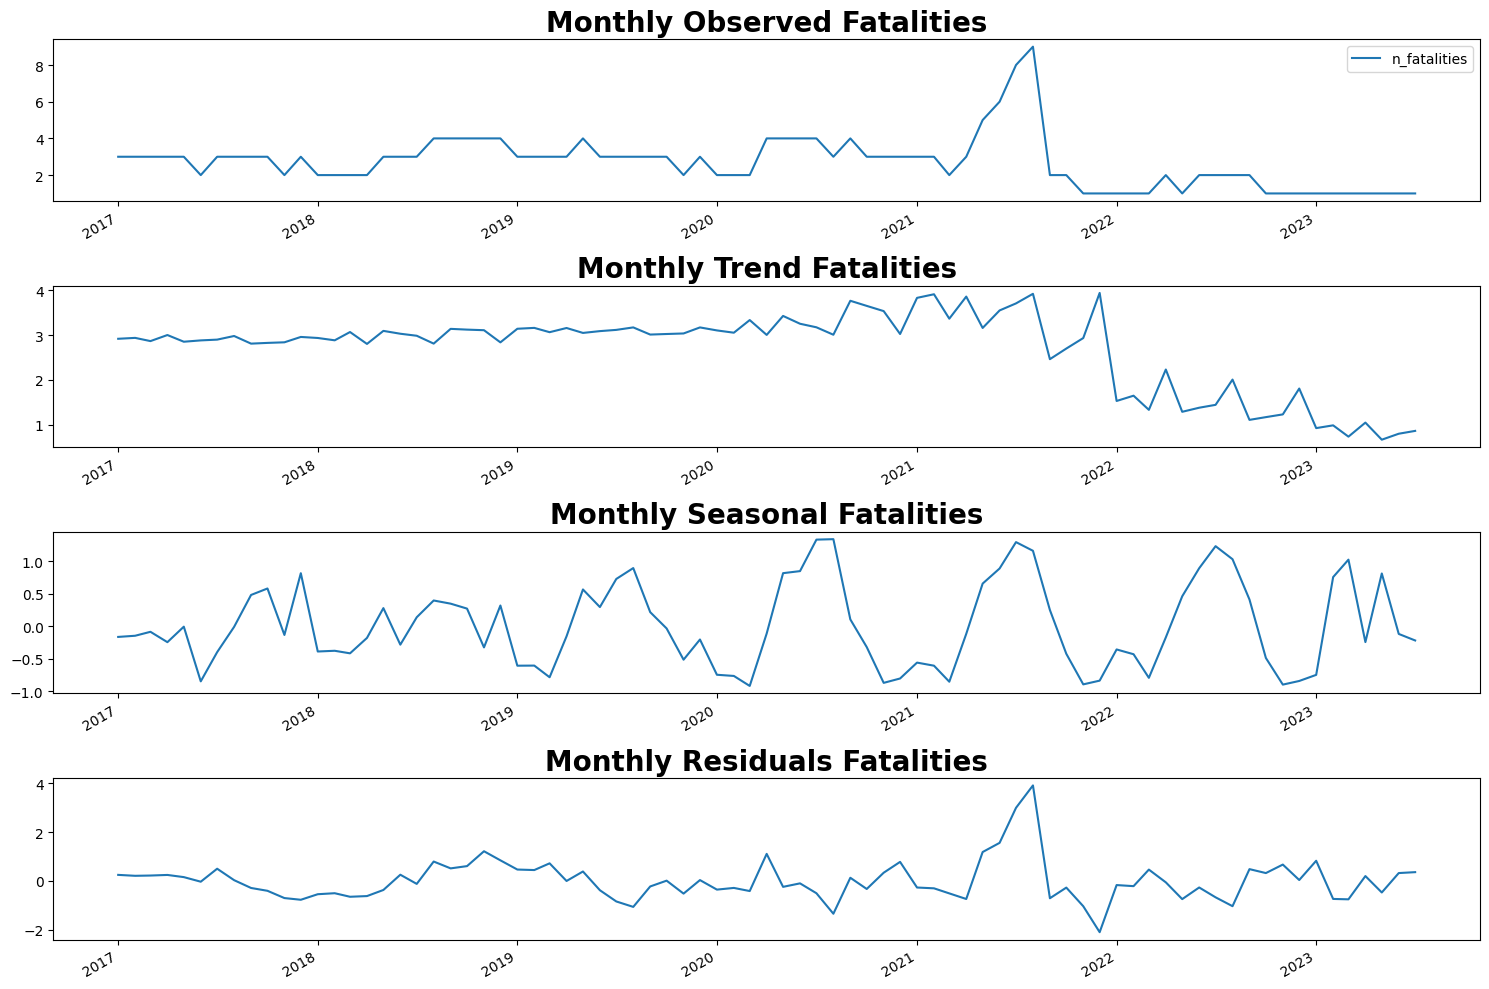

In [15]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(4,1,1)
monthly_stl.observed.plot(ax=ax)
ax.set_title("Monthly Observed Fatalities", fontweight='bold', fontsize=20)

ax = fig.add_subplot(4,1,2)
monthly_stl.trend.plot(ax=ax)
ax.set_title("Monthly Trend Fatalities", fontweight='bold', fontsize=20)

ax = fig.add_subplot(4,1,3)
monthly_stl.seasonal.plot(ax=ax)
ax.set_title("Monthly Seasonal Fatalities", fontweight='bold', fontsize=20)

ax = fig.add_subplot(4,1,4)
monthly_stl.resid.plot(ax=ax)
ax.set_title("Monthly Residuals Fatalities", fontweight='bold', fontsize=20)

plt.tight_layout()

In [23]:
%%time
monthly_fatalities = monthly_fatalities.sort_index()
train: 'Series' = monthly_fatalities[:-24]
test: 'Series' = monthly_fatalities[-24:] # 2 Years
results: defaultdict = defaultdict(list)

p: range = range(4)
d: int = 1
q: range = range(4)

P: range = range(4)
D: int = 0
Q: range = range(4)
s: int = 12

orders: List[tuple] = list(product(p,q,P,Q))

for p,q,P,Q in orders:

    model: SARIMAX = SARIMAX(endog=train,
                                order=(p,d,q),
                                seasonal_order=(P,D,Q,s),
                                enforce_stationarity=False,
                                simple_differencing=False).fit()

    results['p'].append(p)
    results['q'].append(q)
    results['P'].append(P)
    results['Q'].append(Q)
    results['AIC'].append(model.aic)


CPU times: user 2min 35s, sys: 14.2 s, total: 2min 50s
Wall time: 2min 37s


## **Top 25: SARIMAX Model with the lowest AIC**

In [24]:
pd.DataFrame(results).sort_values(by='AIC').head(25)

,p,q,P,Q,AIC
247,3,3,1,3,48.987215
227,3,2,0,3,49.162473
236,3,2,3,0,49.657885
251,3,3,2,3,49.842408
115,1,3,0,3,49.992254
243,3,3,0,3,50.562123
35,0,2,0,3,50.874247
51,0,3,0,3,50.974312
231,3,2,1,3,51.161349
119,1,3,1,3,51.279021


## **SARIMAX(3,1,3),(1,0,3)12**

In [26]:
model: SARIMAX = SARIMAX(endog=train,
                         order=(3,1,3),
                         seasonal_order=(1,0,3,12),
                         simple_differencing=False).fit()

In [27]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       n_fatalities   No. Observations:                   55
Model:             SARIMAX(3, 1, 3)x(1, 0, 3, 12)   Log Likelihood                 -55.877
Date:                            Sun, 30 Jul 2023   AIC                            133.755
Time:                                    02:06:44   BIC                            155.634
Sample:                                01-01-2017   HQIC                           142.193
                                     - 07-01-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1717      1.119     -0.153      0.878      -2.365       2.022
ar.L2          0.1949      1.259      0.155      0.877      -2.272       2.662
ar.L3          0.7097      0.946      0.750      0.453      -1.145       2.565
ma.L1          0.0971     93.974      0.001      0.999    -184.088     184.282
ma.L2         -0.0077     88.422  -8.66e-05      1.000    -173.312     173.297
ma.L3         -0.9564    170.099     -0.006      0.996    -334.345     332.432
ar.S.L12       0.8778      1.739      0.505      0.614      -2.531       4.286
ma.S.L12      -0.5700      1.910     -0.298      0.765      -4.313       3.173
ma.S.L24      -0.2065      0.664     -0.311      0.756      -1.508       1.095
ma.S.L36       0.0560      0.978      0.057      0.954      -1.861       1.973
sigma2         0.4218     75.059      0.006      0.996    -146.691     147.535
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 4.73
Prob(Q):                              0.99   Prob(JB):                         0.09
Heteroskedasticity (H):               3.74   Skew:                             0.68
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

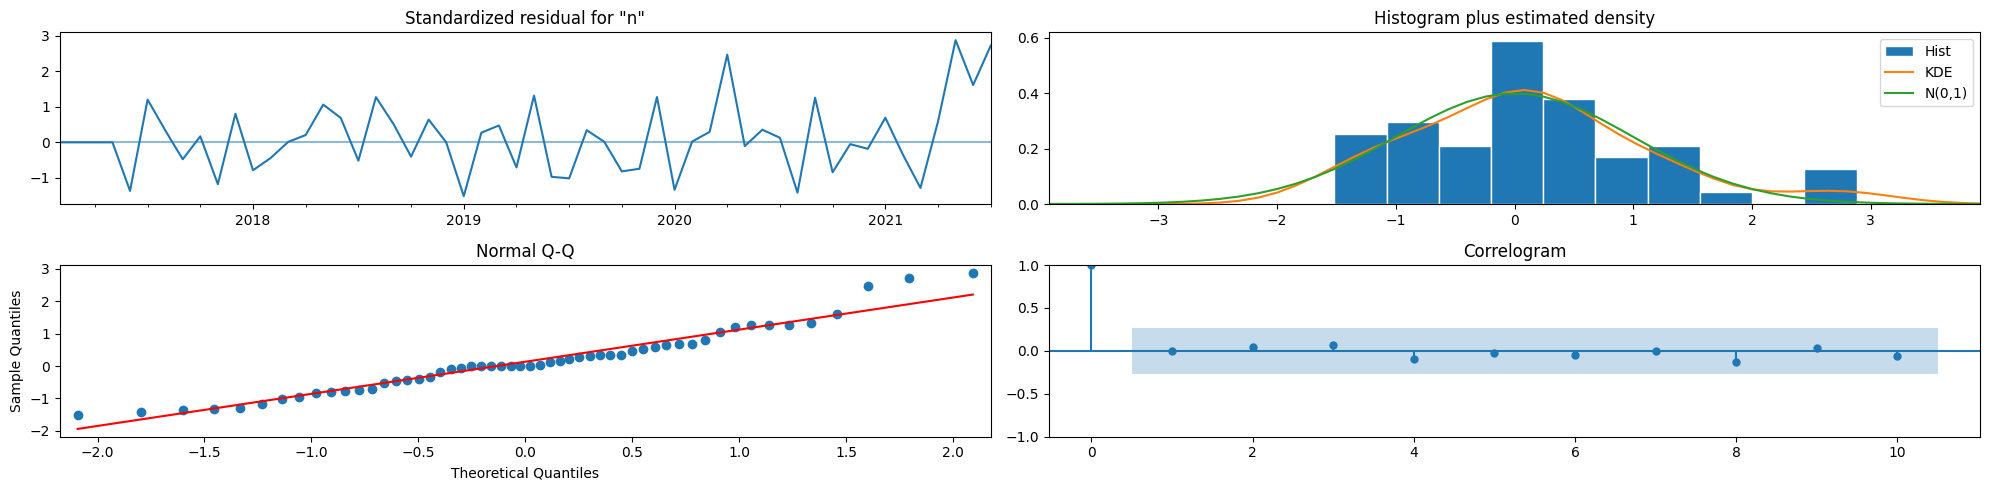

In [28]:
ax = model.plot_diagnostics(figsize=(20,5))
plt.tight_layout()

## **Ljung-Box Test**

In [29]:
acorr_ljungbox(model.resid, lags=20) # good: lb_pvalue > 0.5

,lb_stat,lb_pvalue
1,0.011038,0.916327
2,0.070159,0.965529
3,0.215390,0.975067
4,0.531289,0.970384
5,1.226490,0.942311
6,1.320497,0.970515
7,1.345816,0.987173
8,2.425537,0.965113
9,2.496501,0.980977
10,3.574322,0.964514


## **Rolling Window**

In [62]:
WINDOW: int = 12
HORIZON: int = 24

last_values: List = []
predicted_fatalities: List = []

for index in range(len(train), monthly_fatalities.shape[0] , 12):

    # last values
    last_values.extend(monthly_fatalities.iloc[index - WINDOW:index].values.reshape(1,-1)[0])

    model: SARIMAX = SARIMAX(endog=train,
                         order=(3,1,3),
                         seasonal_order=(1,0,3,12),
                         simple_differencing=False).fit()


    predicted_fatalities.extend( model.get_prediction(0, index + WINDOW - 1).predicted_mean.iloc[-WINDOW:].tolist() )

## **Model Evaluation**
    - MAPE
    - MAE

In [66]:
pd.DataFrame({'Last Values': metrics.mean_absolute_percentage_error(y_true=test, y_pred=last_values),
              'Predicted Values' : metrics.mean_absolute_percentage_error(y_true=test, y_pred=predicted_fatalities) }, index=['MAPE']).transpose()

,MAPE
Last Values,1.173611
Predicted Values,4.604661


In [67]:
pd.DataFrame({'Last Values': metrics.mean_absolute_error(y_true=test, y_pred=last_values),
              'Predicted Values' : metrics.mean_absolute_error(y_true=test, y_pred=predicted_fatalities) }, index=['MAE']).transpose()

,MAE
Last Values,1.833333
Predicted Values,5.425333


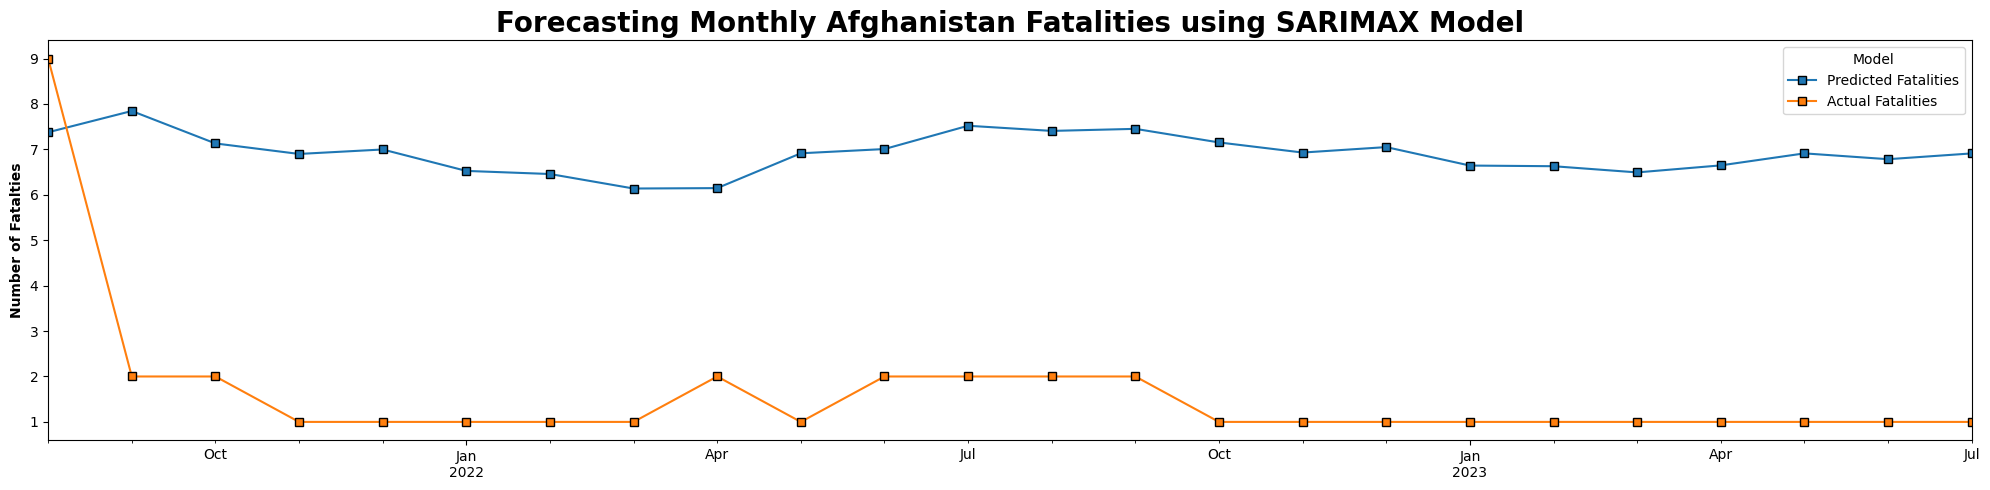

In [45]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot()

model.forecast(steps=test.shape[0]).plot(label="Predicted Fatalities", ax=ax, mec='black', marker='s')
test.rename({'n_fatalities': 'Actual Fatalities'}, axis=1).plot(ax=ax, marker='s', mec='black')
ax.set_ylabel("Number of Fatalties", fontweight='bold')
ax.legend(title="Model")
ax.set_title("Forecasting Monthly Afghanistan Fatalities using SARIMAX Model", fontweight='bold', fontsize=20)

plt.tight_layout()